In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import scipy
from matplotlib import gridspec

import os
import sys
sys.path.append("..")

from sleeprnn.data import utils
from sleeprnn.data.mass_raw import MassRaw
from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader

In [2]:
def filter_frequencies(f, x, f_min, f_max):
    valid_locs = np.where((f>=f_min) & (f<=f_max))[0]
    f = f[valid_locs]
    x = x[valid_locs]
    return f, x


def get_spectrum(x, fs, window_duration=5):
    window_size = int(fs * window_duration)
    x = x.reshape(-1, window_size)
    window_shape = np.hanning(window_size).reshape(1, -1)
    x = x * window_shape
    y = np.fft.rfft(x, axis=1) / window_size
    y = np.abs(y).mean(axis=0)
    f = np.fft.rfftfreq(window_size, d=1./fs)
    return f, y

# MASS-SS2-Train mean spectrum

In [3]:
mass = MassRaw()
fs = mass.fs
# Stages: ['1' '2' '3' '4' '?' 'R' 'W']

In [4]:
stages_for_spectrum = ['2']
powers = []
freq_axis = []
for subject_id in mass.train_ids:
    signal, hypnogram = mass.get_subject_data(subject_id)
    valid_locs = np.isin(hypnogram, stages_for_spectrum)
    signal = signal.reshape(-1, mass.page_size)
    signal = signal[valid_locs, :]
    signal = signal.flatten()
    freq, power_mean = get_spectrum(signal, fs)
    powers.append(power_mean)
    freq_axis.append(freq)
freq_axis = np.stack(freq_axis, axis=0).mean(axis=0)
powers = np.stack(powers, axis=0)

In [5]:
def fit_power_law(f, p, f_min=0.1, f_max=40):
    # p = af^b -> log(p) = log(a) + b*log(f)
    valid_locs = np.where((f>=f_min) & (f<=f_max))[0]
    log_p = np.log(p[valid_locs])
    log_f = np.log(f[valid_locs])
    polycoefs = np.polynomial.Polynomial.fit(log_f, log_p, deg=1).convert().coef
    scale = polycoefs[0]
    exponent = polycoefs[1]
    return exponent, scale

def find_offset(freq_axis, power, offset_grid, f_min=0.1, f_max=40):
    error_list = []
    for offset in offset_grid:
        exponent, scale = fit_power_law(freq_axis + offset, power, f_min, f_max)
        power_fit = np.exp(scale) * ((freq_axis + offset) ** exponent)
        error = np.abs((power_fit - power)**2).mean()
        error_list.append(error)
    best = np.argmin(error_list)
    return offset_grid[best]

def find_offset_power_law(freq_axis, power, f_min=0.1, f_max=40, fit_offset=False):
    if fit_offset:
        offset_grid = np.linspace(0, 10, 2000)
        offset = find_offset(freq_axis, power, offset_grid, f_min, f_max)
    else:
        offset = 0
    exponent, scale = fit_power_law(freq_axis + offset, power, f_min, f_max)
    return scale, offset, exponent

Found exponent (17-100 Hz): -1.5568501327864797


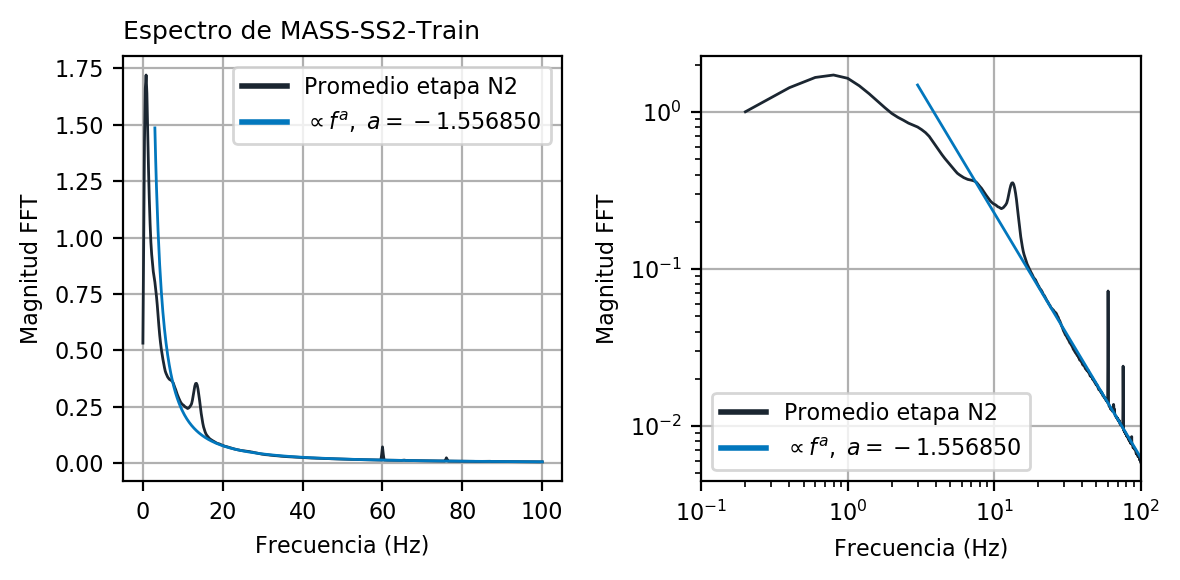

In [6]:
powers_mean = powers.mean(axis=0)
f, p = filter_frequencies(freq_axis, powers_mean, 0, 100)
scale, _, exponent = find_offset_power_law(f, p, f_min=17, f_max=100)
f_start_tran = 9
f_end_tran = 11
transition_curve = (f - f_start_tran) / (f_end_tran - f_start_tran)
transition_curve = np.clip(transition_curve, a_min=0, a_max=1)
curve_fit = np.exp(scale) * np.clip(f, a_min=.1, a_max=None) ** exponent
p_law_copy = p * (1 - transition_curve) + transition_curve * curve_fit
print("Found exponent (17-100 Hz):", exponent)
f_fit_plot, p_fit_plot = filter_frequencies(f, curve_fit, 3, 100)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

ax = axes[0]
ax.set_title("Espectro de MASS-SS2-Train", fontsize=9, loc="left")
ax.plot(f, p, linewidth=1, color=viz.PALETTE['dark'], label="Promedio etapa N2")
ax.plot(
    f_fit_plot, p_fit_plot, linewidth=1, color=viz.PALETTE['blue'],
    label="$\propto f^a,\ a=%1.6f$" % exponent)
ax.set_ylabel("Magnitud FFT", fontsize=8)
ax.set_xticks([0, 20, 40, 60, 80, 100])

ax = axes[1]
f_log, p_log = filter_frequencies(f, p, 0.1, 100)
_, p_law_log = filter_frequencies(f, p_law_copy, 0.1, 100)
ax.loglog(f_log, p_log, linewidth=1, color=viz.PALETTE['dark'], label="Promedio etapa N2")
ax.loglog(
    f_fit_plot, p_fit_plot, linewidth=1, color=viz.PALETTE['blue'], 
    label="$\propto f^a,\ a=%1.6f$" % exponent)
ax.set_xlim([0.1, 100])
ax.set_ylabel("Magnitud FFT", fontsize=8)

for ax in axes.flatten():
    ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
    # ax.set_yticks([])
    ax.grid()
    ax.tick_params(labelsize=8)

leg = axes[0].legend(loc="upper right", fontsize=8)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
leg = axes[1].legend(loc="lower left", fontsize=8)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
plt.tight_layout()

fname_prefix = "espectro_mass_power_law_fit"
# plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.5)
# plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.5)
# plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.5)

plt.show()

In [7]:
# Save curve for interpolation purposes
# curve_to_save = np.stack([f, p_law_copy], axis=0)
# np.save("pink_profile.npy", curve_to_save)
# pink_profile = curve_to_save
pink_profile = np.load(os.path.join(utils.PATH_DATA, 'pink', "pink_profile.npy"))

# PINK v2

In [8]:
fs = 200

In [9]:
mass = reader.load_dataset(constants.MASS_SS_NAME, load_checkpoint=True, verbose=False)

In [10]:
signals = []
for subject_id in mass.train_ids:
    signal, _ = mass.get_subject_data(subject_id, which_expert=1, normalize_clip=False)
    signals.append(signal.flatten())
signals = np.concatenate(signals)
freq_mass, power_mass = get_spectrum(signals, fs)
power_mass_in_band = power_mass[freq_mass <= 8].mean()
print(power_mass_in_band)

0.7726401500724518


In [11]:
def get_profile_fn(pink_profile):
    profile_fn = scipy.interpolate.interp1d(pink_profile[0], pink_profile[1])
    return profile_fn


def generate_signal(n_seconds, fs, seed, profile_fn):
    n_samples = int(n_seconds * fs)
    x = np.random.RandomState(seed=seed).normal(size=n_samples)
    y = np.fft.rfft(x)
    freq_gen = np.fft.rfftfreq(x.size, d=1./fs)
    scaling = profile_fn(freq_gen)
    y = y * scaling
    x = np.fft.irfft(y)
    x = x - x.mean()
    x = x / x.std()
    # Scale
    mass_delta_theta_power = 0.728648
    x = utils.broad_filter(x, fs)
    f, p = get_spectrum(x, fs)
    power_in_band = p[f <= 8].mean()
    x = x * mass_delta_theta_power / power_in_band
    return x

In [12]:
pink_seconds = 3600 * 3
profile_fn = get_profile_fn(pink_profile)
pink_signal = generate_signal(pink_seconds, fs, 0, profile_fn)
pink_signal = pink_signal.reshape(-1, 4000)

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


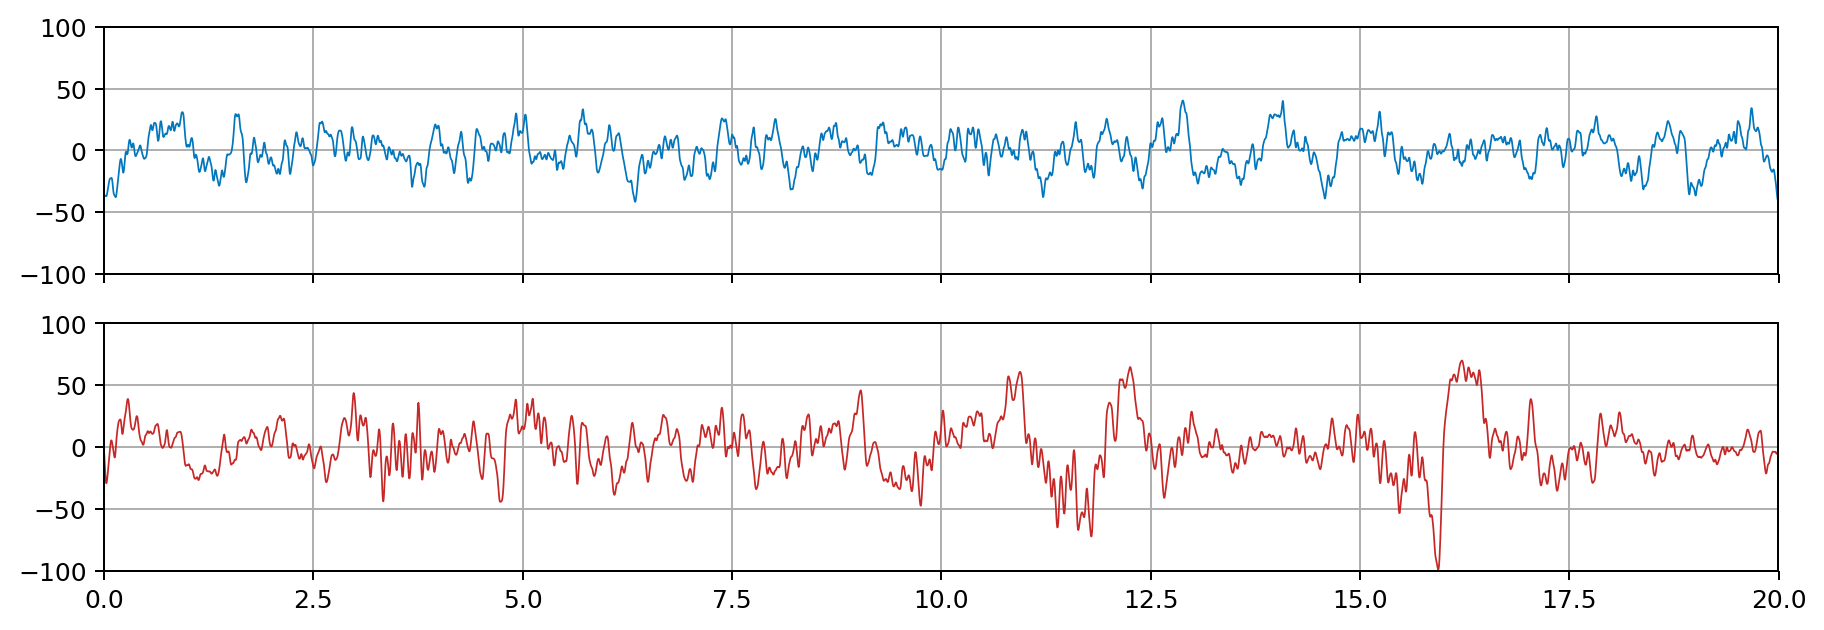

In [13]:
subject_id_mass = 1
mass_signal, _ = mass.get_subject_data(subject_id_mass, which_expert=1, normalize_clip=False)

which_pink = 11
which_mass = 121
fig, ax = plt.subplots(2, 1, figsize=(12, 4), dpi=180, sharex=True)
time_axis = np.arange(4000) / fs
ax[0].plot(time_axis, pink_signal[which_pink, :], linewidth=0.7, color=viz.PALETTE['blue'])
ax[1].plot(time_axis, mass_signal[which_mass, :], linewidth=0.7, color=viz.PALETTE['red'])
for s_ax in ax.flatten():
    s_ax.set_ylim([-100, 100])
    s_ax.set_xlim([time_axis[0], time_axis[-1]])
    s_ax.grid()
plt.show()

In [14]:
freq_mass, power_mass = get_spectrum(signals, fs)
freq_mass, power_mass = filter_frequencies(freq_mass, power_mass, 0.1, 100)

freq_pink, power_mean_pink = get_spectrum(pink_signal.flatten(), fs)
freq_pink, power_mean_pink = filter_frequencies(freq_pink, power_mean_pink, 0.1, 100)

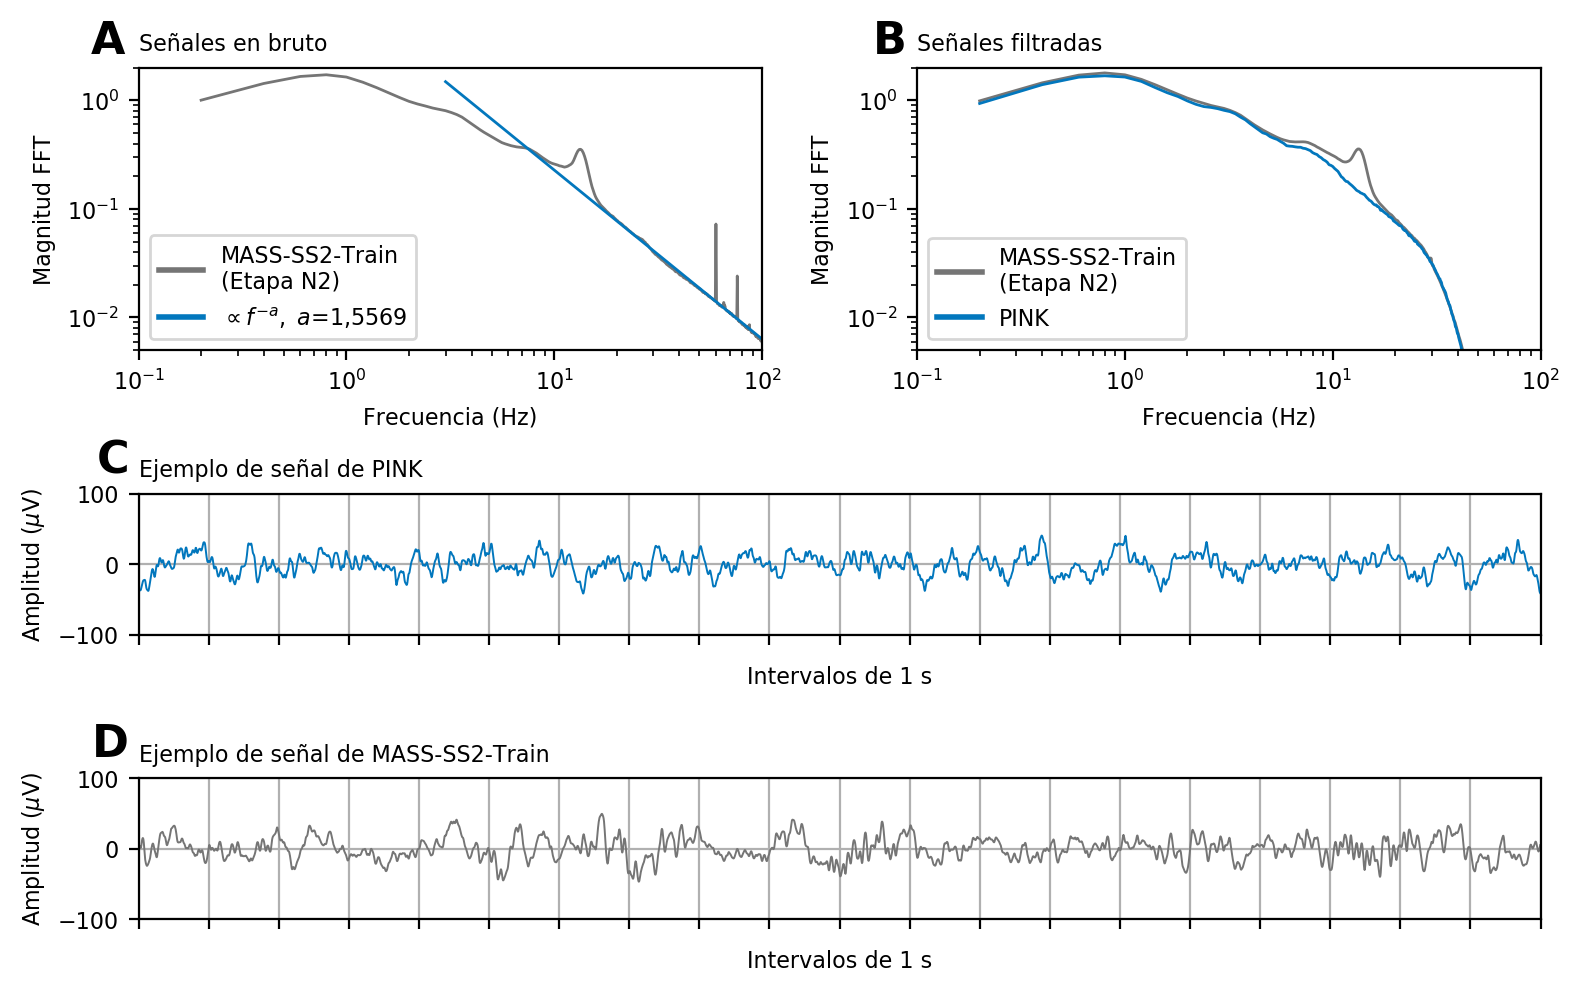

In [20]:
fig = plt.figure(figsize=(8, 5), dpi=200) 
gs = gridspec.GridSpec(3, 2, height_ratios=[2, 1, 1]) 

# fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=120)

ax = fig.add_subplot(gs[0, 0])
ax.set_title("Señales en bruto", fontsize=8, loc="left")
ax.loglog(f_log, p_log, linewidth=1, color=viz.GREY_COLORS[6], 
          label="MASS-SS2-Train\n(Etapa N2)")
exponent_str = ("%1.4f" % (-exponent)).replace('.',',')
ax.loglog(
    f_fit_plot, p_fit_plot, linewidth=1, color=viz.PALETTE['blue'], 
    label="$\propto f^{-a},\ a$=%s" % exponent_str)
ax.set_xlim([0.1, 100])
ax.set_ylim([5e-3, 2])
ax.set_ylabel("Magnitud FFT", fontsize=8)
leg = ax.legend(loc="lower left", fontsize=8)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
ax.tick_params(labelsize=8)
ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
ax1 = ax

ax = fig.add_subplot(gs[0, 1])
ax.set_title("Señales filtradas", fontsize=8, loc="left")
label = "MASS-SS2-Train\n(Etapa N2)"
ax.loglog(freq_mass, power_mass, color=viz.GREY_COLORS[6], linewidth=1, label=label)
ax.loglog(freq_pink, power_mean_pink, color=viz.PALETTE['blue'], linewidth=1, label="PINK")
# ax.set_yticks([])
ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
ax.set_ylabel("Magnitud FFT", fontsize=8)
leg = ax.legend(loc="lower left", fontsize=8)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
ax.set_ylim([5e-3, 2])
ax.set_xlim([0.1, 100])
ax.tick_params(labelsize=8)
ax2 = ax

ax = fig.add_subplot(gs[1, :])
ax.set_title("Ejemplo de señal de PINK", fontsize=8, loc="left")
n_seconds_to_demo = 20
demo_signal = pink_signal[11, :(fs * n_seconds_to_demo)]
time_axis = np.arange(demo_signal.size) / fs
ax.plot(time_axis, demo_signal, linewidth=0.7, color=viz.PALETTE['blue'])
ax.set_ylim([-100, 100])
ax.set_xlim([time_axis[0], time_axis[-1]])
ax.set_xticks(np.arange(n_seconds_to_demo + 1))
ax.set_xticklabels([])
ax.set_xlabel("Intervalos de 1 s", fontsize=8)
ax.set_ylabel("Amplitud ($\mu$V)", fontsize=8)
ax.grid()
ax.tick_params(labelsize=8)
ax3 = ax

ax = fig.add_subplot(gs[2, :])
ax.set_title("Ejemplo de señal de MASS-SS2-Train", fontsize=8, loc="left")
n_seconds_to_demo = 20
demo_signal = mass_signal[122, :(fs * n_seconds_to_demo)]
time_axis = np.arange(demo_signal.size) / fs
ax.plot(time_axis, demo_signal, linewidth=0.7, color=viz.GREY_COLORS[6])
ax.set_ylim([-100, 100])
ax.set_xlim([time_axis[0], time_axis[-1]])
ax.set_xticks(np.arange(n_seconds_to_demo + 1))
ax.set_xticklabels([])
ax.set_xlabel("Intervalos de 1 s", fontsize=8)
ax.set_ylabel("Amplitud ($\mu$V)", fontsize=8)
ax.grid()
ax.tick_params(labelsize=8)
ax4 = ax

plt.tight_layout()

ax1.text(
    x=-0.02, y=1.05, fontsize=16, 
    s=r"$\bf{A}$", 
    ha="right", transform=ax1.transAxes)
ax2.text(
    x=-0.02, y=1.05, fontsize=16, 
    s=r"$\bf{B}$", 
    ha="right", transform=ax2.transAxes)
ax3.text(
    x=-0.008, y=1.15, fontsize=16, 
    s=r"$\bf{C}$", 
    ha="right", transform=ax3.transAxes)
ax4.text(
    x=-0.008, y=1.15, fontsize=16, 
    s=r"$\bf{D}$", 
    ha="right", transform=ax4.transAxes)

fname_prefix = "pink_spectrum_and_signal"
plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.5)
plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.5)
plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.5)

plt.show()